Convert XML format dataset labels into darknet format

In [94]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys, glob
from bs4 import BeautifulSoup
from tqdm import tqdm
import random

In [112]:
!mkdir -p yolo
!mkdir -p yolo/images
!mkdir -p yolo/labels
!mkdir -p yolo/checkpoints
!mkdir -p dataset/samples

In [108]:
CLASSES_ORIG = ["with_mask", "without_mask", "mask_weared_incorrect"]
CLASSES_NAME = ["with_mask", "without_mask", "mask_worn_incorrectly"]

def parse(name):
    img_file = "dataset/images/{}.png".format(name)
    lab_file = "dataset/annotations/{}.xml".format(name)
    sample_file = "dataset/samples/{}.png".format(name)
    
    img = cv2.imread(img_file)
    
    img_orig = img.copy()
    
    with open(lab_file, "r") as f:
        labels = BeautifulSoup(f.read())
        
    labels_obj = []
        
    for l in labels.annotation.findAll("object"):
        class_name = l.findAll("name")[0].text
        assert class_name in CLASSES
        labels_obj.append({
            "class": CLASSES.index(class_name),
            "x0": int(l.bndbox.xmin.text),
            "y0": int(l.bndbox.ymin.text),
            "x1": int(l.bndbox.xmax.text),
            "y1": int(l.bndbox.ymax.text),
        })
        
    for l in labels_obj:
        if l["class"] == 0:
            color = (0, 255, 0)
        elif l["class"] == 1:
            color = (0, 0, 255)
        elif l["class"] == 2:
            color = (0, 180, 255)
        else:
            color = (255, 255, 255)

        cv2.rectangle(img, (l["x0"], l["y0"]), (l["x1"], l["y1"]), color, 2) 
    
    cv2.imwrite(sample_file, img)
    cv2.imwrite("yolo/images/{}.png".format(name), img_orig)
    
    with open("yolo/labels/{}.txt".format(name), "w+") as f:
        for l in labels_obj:
            cx = (l["x0"] + l["x1"]) / 2.0
            cy = (l["y0"] + l["y1"]) / 2.0
            w = abs(l["x0"] - l["x1"])
            h = abs(l["y0"] - l["y1"])
            
            f.write("{} {} {} {} {}\n".format(int(l["class"]),
                                            float(cx) / img_orig.shape[1],
                                            float(cy) / img_orig.shape[0],
                                            float(w) / img_orig.shape[1],
                                            float(h) / img_orig.shape[0]))
    
    return img, labels_obj

In [109]:
names = sorted([os.path.splitext(os.path.basename(x))[0] for x in glob.glob("dataset/images/*.png")])

random.seed(42)
random.shuffle(names)

train = names[:int(0.85 * len(names))]
test = names[int(0.85 * len(names)):]

print("Total:", len(names))
print("Train:", len(train))
print("Test:", len(test))

for name in tqdm(names):
    parse(name)
    

  0%|          | 4/853 [00:00<00:28, 29.49it/s]

Total: 853
Train: 725
Test: 128


100%|██████████| 853/853 [00:25<00:00, 33.96it/s]


In [113]:
classes_text = "\n".join(CLASSES_NAME)
with open("yolo/custom.names", "w+") as f:
    f.write(classes_text)
    
with open("yolo/detector.data", "w+") as f:
    f.write("classes={}\ntrain=train.txt\nvalid=test.txt\nnames=custom.names\nbackup=checkpoints".format(len(CLASSES)))
    
with open("yolo/train.txt", "w+") as f:
    for name in train:
        f.write("images/{}.png\n".format(name))
        
with open("yolo/test.txt", "w+") as f:
    for name in test:
        f.write("images/{}.png\n".format(name))

[{'class': 0, 'x0': 3, 'y0': 151, 'x1': 51, 'y1': 234}, {'class': 1, 'x0': 162, 'y0': 9, 'x1': 178, 'y1': 27}, {'class': 0, 'x0': 117, 'y0': 7, 'x1': 141, 'y1': 26}, {'class': 0, 'x0': 11, 'y0': 1, 'x1': 33, 'y1': 12}, {'class': 0, 'x0': 93, 'y0': 37, 'x1': 114, 'y1': 59}, {'class': 0, 'x0': 125, 'y0': 37, 'x1': 153, 'y1': 65}, {'class': 1, 'x0': 228, 'y0': 48, 'x1': 244, 'y1': 67}, {'class': 1, 'x0': 209, 'y0': 61, 'x1': 233, 'y1': 84}, {'class': 0, 'x0': 264, 'y0': 27, 'x1': 287, 'y1': 53}, {'class': 0, 'x0': 322, 'y0': 43, 'x1': 340, 'y1': 65}, {'class': 0, 'x0': 295, 'y0': 117, 'x1': 328, 'y1': 146}, {'class': 0, 'x0': 361, 'y0': 86, 'x1': 386, 'y1': 109}, {'class': 0, 'x0': 185, 'y0': 99, 'x1': 213, 'y1': 130}]


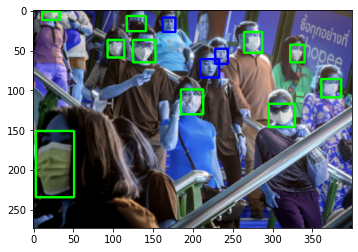

In [111]:
i, l = parse("maksssksksss61")
plt.imshow(i)
print(l)